
## Exploration (EDA) für `spotify.sqlite`

**Ziel:** Diese Notebook führt eine EDA für den bereitgestellten Spotify-Basisdatensatz (SQLite) durch.

In [22]:
# --- Grundlegendes Setup ---
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Matplotlib: keine Styles/keine festen Farben setzen
plt.rcParams.update({'figure.figsize': (8, 5), 'axes.grid': True})

# Verbindung nur für Schema-Abfrage (UTF-8/Bytes egal, da keine Daten gelesen werden)
pd.set_option('display.max_colwidth', None)


### Global Configurations


In [23]:
# ================================================================
# GLOBAL CONFIGURATION (CHANGE ONLY THE SLICE SECTION)
# ================================================================

from pathlib import Path
import json
import datetime

# ------------------------------------------------
# 1) PROJECT PATHS
# ------------------------------------------------
# Absolute project root (Windows)
PROJECT_ROOT = Path(r"C:\GitHub\uni-project-metrics-and-data")

# Data dirs
DATA_RAW_DIR     = PROJECT_ROOT / "data" / "raw"
DATA_INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
DATA_REPORTS_DIR = PROJECT_ROOT / "data" / "reports"


# Raw DB
RAW_SPOTIFY_DB_PATH = DATA_RAW_DIR / "spotify.sqlite"


# ------------------------------------------------
# 2) CURRENT SLICE (ONLY CHANGE THIS PART)
# ------------------------------------------------
SAMPLE_NAME = "slice_001"      # slice_000 | slice_001 | slice_002
ROW_K_START = 7                 # slice_000 → 0 | slice_001 → 7 | slice_002 → 14

# ------------------------------------------------
# 3) DATA & REPORT LOCATIONS FOR THIS SLICE
# ------------------------------------------------
EXPORT_DIR = DATA_INTERIM_DIR / "converted_sqlite_samples" / SAMPLE_NAME
SCHEMA_REPORTS_DIR = DATA_REPORTS_DIR / "schema_overview" /  SAMPLE_NAME


# ----------------------------------------------------------------
# SAMPLE SELECTOR (NEW)
# ----------------------------------------------------------------
CURRENT_SAMPLE_POINTER = DATA_INTERIM_DIR / "converted_sqlite_samples"

# ----------------------------------------------------------------
# Target sample size
# ----------------------------------------------------------------
TARGET_TRACKS = 300_000


for d in [EXPORT_DIR,DATA_REPORTS_DIR,DATA_INTERIM_DIR ,SCHEMA_REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------
# 4) SAMPLING DESCRIPTION (DOCUMENTATION ONLY)
# ------------------------------------------------
# The actual sampling happens in Notebook 01.
# These values are stored for transparency & reproducibility.

    SAMPLING_CONFIG = {
    "method": "ROWID multi-bucket slicing",
    "row_mod": 200,
    "buckets_per_slice": 7,
    "row_k_start": ROW_K_START,
    "target_tracks": 300_000
}

# ------------------------------------------------
# 5) SAVE METADATA (ONCE PER SLICE)
# ------------------------------------------------
META_PATH = DATA_INTERIM_DIR / "converted_sqlite_samples" / "current_sample.json"


META_PATH.write_text(json.dumps({
        "SAMPLE_NAME": SAMPLE_NAME,
        "CREATED_AT": datetime.datetime.now(datetime.UTC).isoformat(),
        "SAMPLING_CONFIG": SAMPLING_CONFIG,
    }, indent=2))

print("Active slice:", SAMPLE_NAME)
print("Buckets:", list(range(ROW_K_START, ROW_K_START + 7)))
print("Data dir:", EXPORT_DIR)
print("Reports dir:", DATA_REPORTS_DIR / SAMPLE_NAME)


Active slice: slice_001
Buckets: [7, 8, 9, 10, 11, 12, 13]
Data dir: C:\GitHub\uni-project-metrics-and-data\data\interim\converted_sqlite_samples\slice_001
Reports dir: C:\GitHub\uni-project-metrics-and-data\data\reports\slice_001


### 1.1 Datenbankstruktur und Tabellenübersicht

Bevor ich mit der eigentlichen Analyse beginne, will ich ein klares Verständnis der Struktur des Spotify-Datenbestands gewinnen.
Dazu prüfe ich:
- Welche Tabellen existieren in der SQLite-Datenbank
- Wie viele Zeilen jede Tabelle enthält
- Welche Spalten und Datentypen sie besitzen
- Welche Felder Primärschlüssel sind


In [24]:


con_overview = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))

# Gibt alle Benutzertabellen (ohne SQLite-Systemtabellen) zurück
def list_user_tables(con):
    q = """
    SELECT name
    FROM sqlite_master
    WHERE type='table' AND name NOT LIKE 'sqlite_%'
    ORDER BY name;
    """
    return pd.read_sql(q, con)['name'].tolist()

# Liest Spalteninformationen einer Tabelle (Name, Typ, Primärschlüssel usw.)
def get_table_info(con, table):
    info = pd.read_sql(f"PRAGMA table_info({table});", con)
    return info

# Gibt die Anzahl der Zeilen einer Tabelle zurück
def get_rowcount(con, table):
    try:
        return pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", con).iloc[0, 0]
    except Exception:
        return None

# Baut eine Gesamtübersicht: Tabellenname, Zeilenanzahl, Spaltenanzahl, Spaltenliste
def build_db_summary(con, max_preview_chars: int = 140):
    tables = list_user_tables(con)
    rows = []
    column_details = {}

    for t in tables:
        info = get_table_info(con, t)
        column_details[t] = info

        # Spaltenliste mit Typ und PK-Markierung
        col_display = [
            f"{r['name']} ({r['type']})" + (" [PK]" if r['pk'] == 1 else "")
            for _, r in info.iterrows()
        ]
        rowcount = get_rowcount(con, t)

        rows.append({
            "table": t,
            "rowcount": rowcount,
            "n_columns": len(col_display),
            "columns_full": ", ".join(col_display)
        })

    summary = pd.DataFrame(rows).sort_values("rowcount", ascending=False)
    # Kürze Spaltenliste für Übersicht (volle Liste bleibt in columns_full)
    summary["columns_preview"] = summary["columns_full"].apply(
        lambda s: s if len(s) <= max_preview_chars else s[:max_preview_chars] + "…"
    )
    summary = summary[["table", "rowcount", "n_columns", "columns_preview", "columns_full"]]
    return summary, column_details

#  Erstelle die Übersicht und zeige sie an
db_summary, db_column_details = build_db_summary(con_overview)

print("Tabellen-Übersicht:")
display(db_summary[["table", "rowcount", "n_columns", "columns_preview"]])

#  Verbindung schließen
con_overview.close()



Tabellen-Übersicht:


,table,rowcount,n_columns,columns_preview
7,r_track_artist,11840402,2,"track_id (), artist_id ()"
5,r_albums_tracks,9900173,2,"album_id (), track_id ()"
8,tracks,8741672,10,"id (), disc_number (), duration (), explicit (), audio_feature_id (), name (), preview_url (), track_number (), popularity (), is_playable (…"
2,audio_features,8740043,15,"id (), acousticness (), analysis_url (), danceability (), duration (), energy (), instrumentalness (), key (), liveness (), loudness (), mod…"
0,albums,4820754,6,"id (), name (), album_group (), album_type (), release_date (), popularity ()"
1,artists,1066031,4,"name (), id (), popularity (), followers ()"
4,r_albums_artists,921486,2,"album_id (), artist_id ()"
6,r_artist_genre,487386,2,"genre_id (), artist_id ()"
3,genres,5489,1,id ()


###  1.2 Überblick über Tabelleninhalte

#### Ziel

Nachdem wir das Schema und die Zeilenzahlen kennen, wollen wir uns nun die Inhalte der wichtigsten Tabellen ansehen.
Wir prüfen einige Beispieleinträge und Datentypen, um zu verstehen, welche Informationen für Analysen relevant sind.

#### Vorgehen

Wir laden jeweils die erste Zeile der Tabellen nur zur Überblick.

In [25]:
key_tables = ['artists', 'tracks', 'audio_features', 'albums', 'genres']
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
for t in key_tables:
    print(f"\n{'='*70}\n Tabelle: {t.upper()}\n{'='*70}")
    try:
        df = pd.read_sql(f"SELECT * FROM {t} LIMIT 5;", con)
        display(df.head())
        print("\n Spaltentypen:")
        display(df.dtypes.to_frame(name="dtype"))
    except Exception as e:
        print(f" Fehler beim Lesen von {t}: {e}")


 Tabelle: ARTISTS


,name,id,popularity,followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665
1,Erick Sermon,2VX0o9LDIVmKIgpnwdJpOJ,54,142007
2,J. Ro,3iBOsmwGzRKyR0vs2I61xP,45,158
3,Tash,22qf8cJRzBjIWb2Jc4JeOr,48,3421
4,Craig Mack,4akj4uteQQrrGxhX9Rjuyf,55,161966



 Spaltentypen:


,dtype
name,object
id,object
popularity,int64
followers,int64



 Tabelle: TRACKS


,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
0,1dizvxctg9dHEyaYTFufVi,1,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),,12,0,NaN
1,2g8HN35AnVGIk7B8yMucww,1,252746,1,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,https://p.scdn.co/mp3-preview/770e023eb0318270ecc5caa018d758e5e0844de9?cid=cde021ca5d3e42a8bd440f1004a562dc,13,77,NaN
2,49pnyECzcMGCKAqxfTB4JZ,3,315080,0,49pnyECzcMGCKAqxfTB4JZ,"You Were Born - Early Version Of ""One Of The Three"" / Outtake",,6,8,1.0
3,4E5IFAXCob6QqZaJMTw5YN,1,240800,1,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,https://p.scdn.co/mp3-preview/f3b556ced9657f8987d2c981014205244daf4540?cid=cde021ca5d3e42a8bd440f1004a562dc,2,70,NaN
4,1gSt2UlC7mtRtJIc5zqKWn,2,203666,0,1gSt2UlC7mtRtJIc5zqKWn,"It's Hard To Say ""I Do"", When I Don't",,2,50,NaN



 Spaltentypen:


,dtype
id,object
disc_number,int64
duration,int64
explicit,int64
audio_feature_id,object
name,object
preview_url,object
track_number,int64
popularity,int64
is_playable,float64



 Tabelle: AUDIO_FEATURES


,id,acousticness,analysis_url,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P,0.893,219160,0.514,0.000000,11,0.0596,-5.080,1,0.283,95.848000,4,0.787
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,https://api.spotify.com/v1/audio-analysis/4JYUDRtPZuVNi7FAnbHyux,0.520,302013,0.847,0.000000,9,0.3250,-5.300,1,0.427,177.371002,4,0.799
2,6YjKAkDYmlasMqYw73iB0w,0.0783,https://api.spotify.com/v1/audio-analysis/6YjKAkDYmlasMqYw73iB0w,0.918,288200,0.586,0.000000,1,0.1450,-2.890,1,0.133,95.516998,4,0.779
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,https://api.spotify.com/v1/audio-analysis/2YlvHjDb4Tyxl4A1IcDhAe,0.877,243013,0.681,0.000000,1,0.1190,-6.277,0,0.259,94.834999,4,0.839
4,3UOuBNEin5peSRqdzvlnWM,0.1700,https://api.spotify.com/v1/audio-analysis/3UOuBNEin5peSRqdzvlnWM,0.814,270667,0.781,0.000518,11,0.0520,-3.330,1,0.233,93.445000,4,0.536



 Spaltentypen:


,dtype
id,object
acousticness,float64
analysis_url,object
danceability,float64
duration,int64
energy,float64
instrumentalness,float64
key,int64
liveness,float64
loudness,float64



 Tabelle: ALBUMS


,id,name,album_group,album_type,release_date,popularity
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",,album,954633600000,0
1,4JYUDRtPZuVNi7FAnbHyux,"Flava in Ya Ear Remix (feat. Notorious B.I.G., L.L. Cool J, Busta Rhymes, Rampage)",,single,757382400000,0
2,6YjKAkDYmlasMqYw73iB0w,Bitch Please II,,album,959040000000,0
3,2YlvHjDb4Tyxl4A1IcDhAe,Just Dippin',,compilation,1104537600000,0
4,3UOuBNEin5peSRqdzvlnWM,Still D.R.E.,,album,942710400000,0



 Spaltentypen:


,dtype
id,object
name,object
album_group,object
album_type,object
release_date,int64
popularity,int64



 Tabelle: GENRES


,id
0,detroit hip hop
1,g funk
2,gangster rap
3,hardcore hip hop
4,hip hop



 Spaltentypen:


,dtype
id,object


### 1.3 Export der Tabellen als CSV-Dateien

**Ziel**
Um effizient mit den Daten arbeiten zu können, exportiere ich ausgewählte Tabellen aus der SQLite-Datenbank als CSV-Dateien.
Dadurch können die weiteren Analysen und Modellierungen mit Pandas durchgeführt werden, ohne die komplette Datenbank bei jedem Schritt erneut laden zu müssen.

**Vorgehen**
- Es werden die zentralen Entitäten (`tracks`, `audio_features`, `artists`, `albums`) sowie die relevanten Beziehungstabellen exportiert.
- Aufgrund der Größe der Datenbank wird **keine Vollkopie**, sondern eine **repräsentative Stichprobe** erzeugt.
- Die Stichprobe wird direkt in der Datenbank mittels SQL erstellt, um Speicherverbrauch und Laufzeit gering zu halten.
- Die Auswahl stellt sicher, dass:
  - das gesamte Popularitätsspektrum abgedeckt ist,
  - seltene, aber relevante Fälle (z. B. sehr populäre Tracks oder explizite Inhalte) enthalten sind,
  - alle exportierten Tabellen zueinander konsistent bleiben.
- Die erzeugten CSV-Dateien werden in einem sample-spezifischen Verzeichnis gespeichert, sodass unterschiedliche Stichproben vergleichbar analysiert werden können.

**Ergebnis**
- Diese Dateien bilden die Grundlage für die explorative Datenanalyse, Feature-Engineering-Schritte und die Modellierung in den folgenden Notebooks.


In [26]:
# ================================================================
# Exportiere eine verbundene, ML-freundliche Stichprobe (<= 300k Tracks)
# aus einer großen Spotify-ähnlichen SQLite-DB, ohne komplette Tabellen
# in pandas zu laden.
#
# UPDATE: ROWID_MOD jetzt so angepasst, dass jede "Slice" ~300k Tracks hat:
#   -> Statt (rowid % ROW_MOD) = k wird jetzt IN (k..k+ROW_BUCKETS_PER_SLICE-1) genutzt
# ================================================================

import sqlite3
import pandas as pd
from pathlib import Path
import json
import time


# Choose sampling mode:
# - "HYBRID_STRATIFIED" (your original logic)
# - "ROWID_MOD"         (systematic slicing; now supports ~300k per slice)
# - "FAST_APPROX"       (fast random-ish)
SAMPLING_MODE = "ROWID_MOD"

# ----------------------------------------------------------------
# Repro/quality knobs
# ----------------------------------------------------------------
REQUIRE_AUDIO_FEATURES = True
MIN_EXPLICIT_SHARE = 0.25
HIT_MIN_POP = 70
HIT_SHARE_IN_SAMPLE = 0.20

# ----------------------------------------------------------------
# For FAST_APPROX randomness
# ----------------------------------------------------------------
APPROX_MOD = 200
APPROX_THRESH = 5

# ----------------------------------------------------------------
# ROWID slicing knobs (IMPORTANT)
# ----------------------------------------------------------------
# ROW_MOD controls how many partitions exist in total. With ~8.7M tracks:
# - ROW_MOD=200 => each bucket ~44k -> need ~7 buckets per slice to reach 300k
ROW_MOD = 200

# how many buckets to UNION per slice to hit ~300k
ROW_BUCKETS_PER_SLICE = 7

# Optional: add randomization to HYBRID_STRATIFIED to get different reruns
HYBRID_RANDOMIZE = True
HYBRID_RANDOM_MOD = 200
HYBRID_RANDOM_THRESH = 10

# ----------------------------------------------------------------
# Connect + PRAGMAs (performance)
# ----------------------------------------------------------------
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
con.text_factory = lambda b: b.decode("utf-8", "replace")

con.execute("PRAGMA journal_mode=OFF;")
con.execute("PRAGMA synchronous=OFF;")
con.execute("PRAGMA temp_store=MEMORY;")
con.execute("PRAGMA cache_size=-200000;")
con.execute("PRAGMA mmap_size=30000000000;")

cur = con.cursor()

# ----------------------------------------------------------------
# Cleanup previous TEMP tables (safe reruns)
# ----------------------------------------------------------------
cur.executescript("""
DROP TABLE IF EXISTS temp.sel_tracks;
DROP TABLE IF EXISTS temp.sel_r_albums_tracks;
DROP TABLE IF EXISTS temp.sel_r_track_artist;
DROP TABLE IF EXISTS temp.sel_albums;
DROP TABLE IF EXISTS temp.sel_artists;
DROP TABLE IF EXISTS temp.sel_audio_features;
DROP TABLE IF EXISTS temp.sel_r_artist_genre;
DROP TABLE IF EXISTS temp.sel_genres;
DROP TABLE IF EXISTS temp.sel_r_albums_artists;
""")

# ----------------------------------------------------------------
# 1) Track selection
# ----------------------------------------------------------------
audio_filter = "AND audio_feature_id IS NOT NULL" if REQUIRE_AUDIO_FEATURES else ""

hybrid_rand_clause = ""
if HYBRID_RANDOMIZE:
    hybrid_rand_clause = f"AND (abs(random()) % {HYBRID_RANDOM_MOD}) < {HYBRID_RANDOM_THRESH}"

if SAMPLING_MODE == "HYBRID_STRATIFIED":

    # Compute quotas
    n_explicit = int(TARGET_TRACKS * MIN_EXPLICIT_SHARE)
    n_hit = int(TARGET_TRACKS * HIT_SHARE_IN_SAMPLE)

    remainder = max(TARGET_TRACKS - n_explicit - n_hit, 0)

    n_b1 = remainder // 4
    n_b2 = remainder // 4
    n_b3 = remainder // 4
    n_b4 = remainder - (n_b1 + n_b2 + n_b3)

    cur.executescript("""
    CREATE TEMP TABLE sel_tracks (
        track_id TEXT PRIMARY KEY,
        disc_number INTEGER,
        duration INTEGER,
        explicit INTEGER,
        audio_feature_id TEXT,
        name TEXT,
        preview_url TEXT,
        track_number INTEGER,
        popularity INTEGER,
        is_playable INTEGER
    );
    CREATE INDEX IF NOT EXISTS idx_sel_tracks_id ON sel_tracks(track_id);
    CREATE INDEX IF NOT EXISTS idx_sel_tracks_af ON sel_tracks(audio_feature_id);
    """)

    # (A) Explicit slice
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 1
          AND popularity IS NOT NULL
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          {hybrid_rand_clause}
        LIMIT {n_explicit};
    """)

    # (B) High-popularity slice
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE popularity >= {HIT_MIN_POP}
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          AND popularity IS NOT NULL
          {hybrid_rand_clause}
        LIMIT {n_hit};
    """)

    # (C) Balanced buckets
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 0 AND 20
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          AND popularity IS NOT NULL
          {hybrid_rand_clause}
        LIMIT {n_b1};
    """)
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 21 AND 40
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          AND popularity IS NOT NULL
          {hybrid_rand_clause}
        LIMIT {n_b2};
    """)
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 41 AND 60
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          AND popularity IS NOT NULL
          {hybrid_rand_clause}
        LIMIT {n_b3};
    """)
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 61 AND {HIT_MIN_POP - 1}
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          AND popularity IS NOT NULL
          {hybrid_rand_clause}
        LIMIT {n_b4};
    """)

    # (D) Filler
    n_now = cur.execute("SELECT COUNT(*) FROM sel_tracks;").fetchone()[0]
    missing = TARGET_TRACKS - n_now

    if missing > 0:
        cur.execute(f"""
            INSERT OR IGNORE INTO sel_tracks
            SELECT id AS track_id,
                   disc_number, duration, explicit, audio_feature_id,
                   name, preview_url, track_number, popularity, is_playable
            FROM tracks
            WHERE (abs(random()) % {APPROX_MOD}) < {APPROX_THRESH}
              {audio_filter}
              AND duration IS NOT NULL AND duration > 0
              AND popularity IS NOT NULL
            LIMIT {missing};
        """)

elif SAMPLING_MODE == "ROWID_MOD":
    # NEW: multiple buckets per slice => ~300k rows per slice
    row_ks = [(ROW_K_START + i) % ROW_MOD for i in range(ROW_BUCKETS_PER_SLICE)]
    row_k_sql = ",".join(map(str, row_ks))
    print(f"[{SAMPLE_NAME}] Using ROWID buckets: {row_ks}")

    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (rowid % {ROW_MOD}) IN ({row_k_sql})
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          AND popularity IS NOT NULL
        LIMIT {TARGET_TRACKS};
    """)

elif SAMPLING_MODE == "FAST_APPROX":
    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (abs(random()) % {APPROX_MOD}) < {APPROX_THRESH}
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
          AND popularity IS NOT NULL
        LIMIT {TARGET_TRACKS};
    """)
else:
    raise ValueError(f"Unknown SAMPLING_MODE: {SAMPLING_MODE}")

# Ensure indexes exist (safe for all modes)
cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_sel_tracks_id ON sel_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_tracks_af ON sel_tracks(audio_feature_id);
""")

# Info print
n_tracks = cur.execute("SELECT COUNT(*) FROM sel_tracks;").fetchone()[0]
print(f"[{SAMPLE_NAME}] Selected tracks: {n_tracks:,} (target {TARGET_TRACKS:,})")

stats = cur.execute("""
SELECT
  SUM(CASE WHEN explicit=1 THEN 1 ELSE 0 END) AS n_explicit,
  SUM(CASE WHEN popularity>=70 THEN 1 ELSE 0 END) AS n_hit_like,
  AVG(popularity) AS avg_pop
FROM sel_tracks;
""").fetchone()
print(f" explicit: {stats[0]:,} | hit-like(pop>=70): {stats[1]:,} | avg popularity: {stats[2]:.2f}")

# ----------------------------------------------------------------
# 2) Filter relation tables (DB-side joins)
# ----------------------------------------------------------------
cur.executescript("""
CREATE TEMP TABLE sel_r_albums_tracks AS
SELECT r.album_id, r.track_id
FROM r_albums_tracks r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rat_track ON sel_r_albums_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rat_album ON sel_r_albums_tracks(album_id);

CREATE TEMP TABLE sel_r_track_artist AS
SELECT r.track_id, r.artist_id
FROM r_track_artist r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rta_track ON sel_r_track_artist(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rta_artist ON sel_r_track_artist(artist_id);
""")

n_rat = cur.execute("SELECT COUNT(*) FROM sel_r_albums_tracks;").fetchone()[0]
n_rta = cur.execute("SELECT COUNT(*) FROM sel_r_track_artist;").fetchone()[0]
print(f" sel_r_albums_tracks: {n_rat:,}")
print(f" sel_r_track_artist:  {n_rta:,}")

# ----------------------------------------------------------------
# 3) Derive linked entity sets (albums, artists, audio_features, genres)
# ----------------------------------------------------------------
cur.executescript("""
CREATE TEMP TABLE sel_albums AS
SELECT a.id, a.name, a.album_group, a.album_type, a.release_date, a.popularity
FROM albums a
JOIN sel_r_albums_tracks rat ON rat.album_id = a.id
GROUP BY a.id;

CREATE INDEX IF NOT EXISTS idx_sel_albums_id ON sel_albums(id);

CREATE TEMP TABLE sel_artists AS
SELECT ar.id, ar.name, ar.popularity, ar.followers
FROM artists ar
JOIN sel_r_track_artist rta ON rta.artist_id = ar.id
GROUP BY ar.id;

CREATE INDEX IF NOT EXISTS idx_sel_artists_id ON sel_artists(id);

CREATE TEMP TABLE sel_audio_features AS
SELECT af.id, af.acousticness, af.analysis_url, af.danceability, af.duration,
       af.energy, af.instrumentalness, af.key, af.liveness, af.loudness,
       af.mode, af.speechiness, af.tempo, af.time_signature, af.valence
FROM audio_features af
JOIN sel_tracks t ON t.audio_feature_id = af.id
GROUP BY af.id;

CREATE INDEX IF NOT EXISTS idx_sel_af_id ON sel_audio_features(id);
""")

cur.executescript("""
DROP TABLE IF EXISTS temp.sel_r_artist_genre;
CREATE TEMP TABLE sel_r_artist_genre AS
SELECT rag.genre_id, rag.artist_id
FROM r_artist_genre rag
JOIN sel_artists a ON a.id = rag.artist_id;

CREATE INDEX IF NOT EXISTS idx_sel_rag_artist ON sel_r_artist_genre(artist_id);
CREATE INDEX IF NOT EXISTS idx_sel_rag_genre  ON sel_r_artist_genre(genre_id);

DROP TABLE IF EXISTS temp.sel_genres;
CREATE TEMP TABLE sel_genres AS
SELECT g.id
FROM genres g
JOIN sel_r_artist_genre rag ON rag.genre_id = g.id
GROUP BY g.id;

CREATE INDEX IF NOT EXISTS idx_sel_genres_id ON sel_genres(id);
""")

cur.executescript("""
DROP TABLE IF EXISTS temp.sel_r_albums_artists;
CREATE TEMP TABLE sel_r_albums_artists AS
SELECT r.album_id, r.artist_id
FROM r_albums_artists r
JOIN sel_albums a ON a.id = r.album_id;

CREATE INDEX IF NOT EXISTS idx_sel_raa_album ON sel_r_albums_artists(album_id);
CREATE INDEX IF NOT EXISTS idx_sel_raa_artist ON sel_r_albums_artists(artist_id);
""")


# ----------------------------------------------------------------
# 4) Export TEMP tables to CSV
# ----------------------------------------------------------------
def dump(name: str, sql: str):
    df = pd.read_sql(sql, con)
    out = EXPORT_DIR / f"{name}.csv"
    df.to_csv(out, index=False, header=True, encoding="utf-8-sig")
    print(f" {name:<20} → {out.name} ({len(df):,} rows)")


dump("tracks", "SELECT * FROM sel_tracks;")
dump("r_albums_tracks", "SELECT * FROM sel_r_albums_tracks;")
dump("r_track_artist", "SELECT * FROM sel_r_track_artist;")
dump("albums", "SELECT * FROM sel_albums;")
dump("artists", "SELECT * FROM sel_artists;")
dump("audio_features", "SELECT * FROM sel_audio_features;")
dump("r_artist_genre", "SELECT * FROM sel_r_artist_genre;")
dump("genres", "SELECT * FROM sel_genres;")
dump("r_albums_artists", "SELECT * FROM sel_r_albums_artists;")

# ----------------------------------------------------------------
# 5) Save selection metadata (repro + audit)
# ----------------------------------------------------------------
df_ids = pd.read_sql("SELECT track_id FROM sel_tracks;", con)
df_ids.to_csv(EXPORT_DIR / "selected_track_ids.csv", index=False)

print("Export complete")


[slice_001] Using ROWID buckets: [7, 8, 9, 10, 11, 12, 13]
[slice_001] Selected tracks: 300,000 (target 300,000)
 explicit: 19,958 | hit-like(pop>=70): 224 | avg popularity: 6.13
 sel_r_albums_tracks: 340,898
 sel_r_track_artist:  407,296
 tracks               → tracks.csv (300,000 rows)
 r_albums_tracks      → r_albums_tracks.csv (340,898 rows)
 r_track_artist       → r_track_artist.csv (407,296 rows)
 albums               → albums.csv (195,938 rows)
 artists              → artists.csv (187,440 rows)
 audio_features       → audio_features.csv (299,954 rows)
 r_artist_genre       → r_artist_genre.csv (194,023 rows)
 genres               → genres.csv (5,455 rows)
 r_albums_artists     → r_albums_artists.csv (224,955 rows)
Export complete


### 1.4 Deskriptive Statistiken & Verteilungen
Ich untersuche numerische Spalten (z. B. Popularity, Energy, Danceability) auf ihre Verteilungen, Ausreißer und Mittelwerte.

In [27]:
BASE_EXPORT_DIR = DATA_INTERIM_DIR / "converted_sqlite_samples"
cfg = json.loads((BASE_EXPORT_DIR / "current_sample.json").read_text())
SAMPLE_NAME = cfg["SAMPLE_NAME"]
DATA_DIR = EXPORT_DIR


print("Using sample:", cfg["SAMPLE_NAME"])


# Lade mehrere Tabellen
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
artists = pd.read_csv(DATA_DIR / "artists.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# -------- Übersicht: Anzahl numerischer Spalten pro Tabelle --------
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    print(f"{name:<15} -> numerische Spalten: {len(num_cols)} | {', '.join(num_cols[:8])}{'...' if len(num_cols)>8 else ''}")

Using sample: slice_001
tracks          -> numerische Spalten: 6 | disc_number, duration, explicit, track_number, popularity, is_playable
audio_features  -> numerische Spalten: 13 | acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness...
artists         -> numerische Spalten: 2 | popularity, followers
albums          -> numerische Spalten: 3 | album_group, release_date, popularity


#### Fast Overview der Tabellen mit describe()

In [28]:
from pathlib import Path

tables = {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}

out_dir = Path(SCHEMA_REPORTS_DIR) / "descriptions"
out_dir.mkdir(parents=True, exist_ok=True)

for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) == 0:
        print(f"skipped {name}: no numeric columns")
        continue

    desc = (
        df[num_cols]
        .describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
        .T.round(2)
    )

    out_file = out_dir / f"{name}_describe.html"

    # Safety: if an old mistake created a DIRECTORY where the file should be, fail clearly
    if out_file.exists() and out_file.is_dir():
        raise RuntimeError(f"{out_file} is a directory. Delete it and rerun.")

    desc.to_html(out_file)  # pathlib Path is fine
    print("saved:", out_file)




saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\descriptions\tracks_describe.html
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\descriptions\audio_features_describe.html
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\descriptions\artists_describe.html
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\descriptions\albums_describe.html


#### Histogramme für ausgewählte numerische Spalten

In [29]:
import matplotlib.pyplot as plt
import numpy as np
HIST_DIR = SCHEMA_REPORTS_DIR / "histograms"
HIST_DIR.mkdir(parents=True, exist_ok=True)

def numeric_profile_grid(
    df,
    cols,
    title,
    bins=40,
    clip_q=(0.01, 0.99),
    log_mode="auto",      # "auto", True, False
    show_box=True,
    save_path=None,       # NEW
):
    """
    Pro EDA Grid pro Feature:
      - links: Histogram (geclippt auf Quantile)
      - rechts: log1p-Hist (bei heavy tails) ODER Boxplot
    """
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("Keine gültigen Spalten gefunden.")
        return

    n = len(cols)
    nrows = n
    ncols = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows))
    if nrows == 1:
        axes = np.array([axes])

    for i, col in enumerate(cols):
        s = df[col]
        s_nonnull = s.dropna()

        missing_rate = 1.0 - (len(s_nonnull) / max(len(s), 1))
        zero_rate = float((s_nonnull == 0).mean()) if len(s_nonnull) else np.nan

        if len(s_nonnull) == 0:
            axes[i, 0].set_title(f"{col} (all missing)")
            axes[i, 0].axis("off")
            axes[i, 1].axis("off")
            continue

        q_low, q_high = s_nonnull.quantile(clip_q[0]), s_nonnull.quantile(clip_q[1])
        s_clip = s_nonnull.clip(q_low, q_high)

        use_log = False
        if log_mode is True:
            use_log = True
        elif log_mode == "auto" and s_nonnull.min() >= 0:
            p50 = s_nonnull.quantile(0.50)
            p99 = s_nonnull.quantile(0.99)
            if p50 > 0 and (p99 / p50) >= 10:
                use_log = True

        # LEFT
        axL = axes[i, 0]
        axL.hist(s_clip.values, bins=bins)
        axL.set_ylabel("count")
        axL.set_title(
            f"{col} | miss={missing_rate:.1%} | zero={zero_rate:.1%} | clip=[{q_low:.3g},{q_high:.3g}]"
        )

        # RIGHT
        axR = axes[i, 1]
        if use_log:
            s_log = np.log1p(s_nonnull.clip(lower=0))
            axR.hist(s_log.values, bins=bins)
            axR.set_title(f"{col} (log1p view)")
        else:
            if show_box:
                axR.boxplot(s_nonnull.values, vert=False, showfliers=True)
                axR.set_title(f"{col} (boxplot)")
            else:
                axR.axis("off")

        for ax in (axL, axR):
            ax.grid(alpha=0.2)

    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.close(fig)
        print("saved:", save_path)
    else:
        plt.show()

# Columns
track_cols = [c for c in ["popularity", "duration", "track_number", "disc_number", "explicit"] if c in tracks.columns]
audio_cols = [c for c in ["danceability", "energy", "loudness", "valence", "tempo",
                          "acousticness", "instrumentalness", "speechiness", "time_signature"] if c in audio.columns]
artist_cols = [c for c in ["popularity", "followers"] if c in artists.columns]
album_cols = [c for c in ["popularity", "release_date"] if c in albums.columns]

numeric_profile_grid(
    tracks,
    track_cols,
    "Tracks – Verteilungen (clipped + log/box)",
    bins=40,
    save_path=HIST_DIR / "tracks_numeric_profiles.png"
)

numeric_profile_grid(
    audio,
    audio_cols,
    "Audio Features – Verteilungen (clipped + log/box)",
    bins=40,
    save_path=HIST_DIR / "audio_features_numeric_profiles.png"
)

numeric_profile_grid(
    artists,
    artist_cols,
    "Artists – Popularität & Follower (clipped + log/box)",
    bins=40,
    save_path=HIST_DIR / "artists_numeric_profiles.png"
)

numeric_profile_grid(
    albums,
    album_cols,
    "Albums – Popularität & Release Date (clipped + log/box)",
    bins=40,
    save_path=HIST_DIR / "albums_numeric_profiles.png"
)







saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\histograms\tracks_numeric_profiles.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\histograms\audio_features_numeric_profiles.png


C:\Users\user\AppData\Local\Temp\ipykernel_28340\2814666648.py:48: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s_clip = s_nonnull.clip(q_low, q_high)


saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\histograms\artists_numeric_profiles.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\histograms\albums_numeric_profiles.png


#### Ausreißer-Erkennung


In [30]:
import numpy as np
import pandas as pd


OUTLIER_DIR = Path(SCHEMA_REPORTS_DIR) / "outliers"
OUTLIER_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# 1) Rule-based validators
# ---------------------------
def default_rules():
    """
    Domain-Rules für Spotify-ähnliche Daten.
    Passe sie bei Bedarf an.
    Jede Rule liefert eine Bool-Maske (True = invalid).
    """
    return {
        # Tracks
        "duration": lambda s: (s <= 0) | (s > 30 * 60 * 1000),          # >30min in ms
        "track_number": lambda s: (s <= 0) | (s > 200),                # >200 sehr verdächtig
        "disc_number": lambda s: (s <= 0) | (s > 10),                  # >10 sehr selten / suspicious
        "popularity": lambda s: (s < 0) | (s > 100),                   # Spotify popularity bounds
        "explicit": lambda s: ~s.isin([0, 1]),

        # Audio
        "tempo": lambda s: (s <= 0) | (s > 300),                       # tempo 0 invalid, >300 rare
        "time_signature": lambda s: ~s.isin([3, 4, 5]),                # 4/4 dominant, 3/4 & 5/4 ok
        "loudness": lambda s: (s < -40) | (s > 5),                     # -60 suspicious, >5 suspicious

    }

# ---------------------------
# 2) Quantile outliers
# ---------------------------
def quantile_outliers(s: pd.Series, low_q=0.005, high_q=0.995):
    s = s.dropna()
    if len(s) == 0:
        return pd.Series([], dtype=bool), (np.nan, np.nan)
    lo, hi = s.quantile(low_q), s.quantile(high_q)
    mask = (s < lo) | (s > hi)
    return mask, (lo, hi)

# ---------------------------
# 3) IQR outliers (classic)
# ---------------------------
def iqr_outliers(s: pd.Series, k=1.5):
    s = s.dropna()
    if len(s) == 0:
        return pd.Series([], dtype=bool), (np.nan, np.nan)
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k * iqr, q3 + k * iqr
    mask = (s < lo) | (s > hi)
    return mask, (lo, hi)

# ---------------------------
# 4) Release-date validation helper
# ---------------------------
def validate_release_date_epoch_ms(series, min_year=1900, max_year=None):
    """
    Erwartet epoch in ms (wie Spotify häufig).
    Gibt invalid mask zurück (True=invalid) + year series.
    """
    s = series.dropna()
    if max_year is None:
        max_year = pd.Timestamp.today().year + 1

    # convert epoch ms -> datetime
    dt = pd.to_datetime(s, unit="ms", errors="coerce")
    year = dt.dt.year

    invalid = dt.isna() | (year < min_year) | (year > max_year)
    return invalid, year

# ---------------------------
# 5) Main analyzer
# ---------------------------
def robust_outlier_report(
    df: pd.DataFrame,
    cols=None,
    q_low=0.005,
    q_high=0.995,
    use_iqr=True,
    iqr_k=1.5,
    rules=None,
    include_indices=False,
):
    """
    Erzeugt einen Report mit:
      - missing%, zero%
      - invalid_count (rules)
      - quantile_outliers_count (+ quantile bounds)
      - iqr_outliers_count (+ iqr bounds)

    include_indices=True -> liefert zusätzlich dict mit indices der auffälligen rows pro col.
    """
    if cols is None:
        cols = df.select_dtypes(include=["number"]).columns.tolist()

    if rules is None:
        rules = default_rules()

    rows = []
    idx_dict = {} if include_indices else None

    n_total = len(df)

    for col in cols:
        if col not in df.columns:
            continue

        s_full = df[col]
        if not pd.api.types.is_numeric_dtype(s_full):
            continue

        s = s_full.dropna()
        n_nonnull = len(s)
        miss_rate = 1 - (n_nonnull / max(n_total, 1))

        # zero-rate (only meaningful for numeric)
        try:
            zero_rate = float((s == 0).mean()) if n_nonnull > 0 else np.nan
        except Exception:
            zero_rate = np.nan

        # ---- rule-based invalids ----
        invalid_count = 0
        invalid_rate = 0.0
        invalid_bounds = None

        if col == "release_date":
            inv_mask, year = validate_release_date_epoch_ms(s_full)
            invalid_count = int(inv_mask.sum())
            invalid_rate = invalid_count / max(n_total, 1)
            invalid_bounds = f"year∉[1900,{pd.Timestamp.today().year+1}] or parse fail"
            if include_indices:
                idx_dict.setdefault(col, {})
                idx_dict[col]["invalid_idx"] = df.index[inv_mask].tolist()
        elif col in rules:
            inv_mask = rules[col](s_full)
            inv_mask = inv_mask.fillna(False)
            invalid_count = int(inv_mask.sum())
            invalid_rate = invalid_count / max(n_total, 1)
            if include_indices:
                idx_dict.setdefault(col, {})
                idx_dict[col]["invalid_idx"] = df.index[inv_mask].tolist()

        # ---- quantile outliers ----
        q_mask, (q_lo, q_hi) = quantile_outliers(s_full, q_low, q_high)
        # q_mask is on dropna() series index; align back:
        q_idx = q_mask[q_mask].index if len(q_mask) else []
        q_count = len(q_idx)
        q_rate = q_count / max(n_total, 1)

        if include_indices:
            idx_dict.setdefault(col, {})
            idx_dict[col]["quantile_idx"] = list(q_idx)

        # ---- iqr outliers ----
        iqr_count = np.nan
        iqr_rate = np.nan
        iqr_lo = np.nan
        iqr_hi = np.nan

        if use_iqr:
            i_mask, (i_lo, i_hi) = iqr_outliers(s_full, iqr_k)
            i_idx = i_mask[i_mask].index if len(i_mask) else []
            iqr_count = len(i_idx)
            iqr_rate = iqr_count / max(n_total, 1)
            iqr_lo, iqr_hi = i_lo, i_hi
            if include_indices:
                idx_dict.setdefault(col, {})
                idx_dict[col]["iqr_idx"] = list(i_idx)

        rows.append({
            "col": col,
            "missing_%": round(miss_rate * 100, 2),
            "zero_%": round(zero_rate * 100, 2) if pd.notna(zero_rate) else np.nan,

            "invalid_n": invalid_count,
            "invalid_%": round(invalid_rate * 100, 3),
            "invalid_rule": invalid_bounds if invalid_bounds else ("custom_rule" if col in rules else ""),

            "q_outliers_n": q_count,
            "q_outliers_%": round(q_rate * 100, 3),
            "q_bounds": f"[{q_lo:.3g}, {q_hi:.3g}]" if pd.notna(q_lo) else "",

            "iqr_outliers_n": iqr_count,
            "iqr_outliers_%": round(iqr_rate * 100, 3) if pd.notna(iqr_rate) else np.nan,
            "iqr_bounds": f"[{iqr_lo:.3g}, {iqr_hi:.3g}]" if pd.notna(iqr_lo) else "",
        })

    report = pd.DataFrame(rows).sort_values(
        by=["invalid_n", "q_outliers_n"],
        ascending=False
    )

    return (report, idx_dict) if include_indices else report


### Anwendung auf die Tabellen

In [31]:
import matplotlib.pyplot as plt

tables = {
    "tracks": tracks,
    "audio_features": audio,
    "artists": artists,
    "albums": albums
}

reports = {}

for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if not num_cols:
        print("skip (no numeric cols):", name)
        continue

    rep = robust_outlier_report(
        df,
        cols=num_cols,
        q_low=0.005,
        q_high=0.995,
        use_iqr=True,
        iqr_k=1.5,
        rules=default_rules(),
        include_indices=False
    )

    reports[name] = rep

    # -------------------------
    # (A) Save FULL reporting as CSV
    # -------------------------
    csv_path = OUTLIER_DIR / f"{name}_robust_outlier_report.csv"
    rep.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print("saved:", csv_path)

    # -------------------------
    # (B) Save TOP-15 as PNG table
    # -------------------------
    top = rep.head(15).copy()

    fig, ax = plt.subplots(figsize=(14, 0.6 * len(top) + 2))
    ax.axis("off")

    tbl = ax.table(
        cellText=top.values,
        colLabels=top.columns,
        cellLoc="center",
        loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)

    png_path = OUTLIER_DIR / f"{name}_robust_outlier_report_top15.png"
    plt.savefig(png_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("saved:", png_path)

    # -------------------------
    # (C) Optional: simple bar chart (invalid_% + q_outliers_%)
    # -------------------------
    # Keep it readable: show top 12 by invalid_n
    plot_df = rep.sort_values("invalid_n", ascending=False).head(12).copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(plot_df["col"], plot_df["invalid_%"])
    ax.set_title(f"{name}: invalid_% (Top 12)")
    ax.set_ylabel("invalid_%")
    ax.tick_params(axis="x", rotation=45)
    fig.tight_layout()

    bar_path = OUTLIER_DIR / f"{name}_invalid_percent_top12.png"
    fig.savefig(bar_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("saved:", bar_path)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(plot_df["col"], plot_df["q_outliers_%"])
    ax.set_title(f"{name}: quantile outliers % (Top 12)")
    ax.set_ylabel("q_outliers_%")
    ax.tick_params(axis="x", rotation=45)
    fig.tight_layout()

    bar_path2 = OUTLIER_DIR / f"{name}_q_outliers_percent_top12.png"
    fig.savefig(bar_path2, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("saved:", bar_path2)



saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\tracks_robust_outlier_report.csv
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\tracks_robust_outlier_report_top15.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\tracks_invalid_percent_top12.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\tracks_q_outliers_percent_top12.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\audio_features_robust_outlier_report.csv
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\audio_features_robust_outlier_report_top15.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\audio_features_invalid_percent_top12.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overvi

C:\Users\user\AppData\Local\Temp\ipykernel_28340\3370807512.py:57: UserWarning: Glyph 8713 (\N{NOT AN ELEMENT OF}) missing from font(s) Arial.
  plt.savefig(png_path, dpi=200, bbox_inches="tight")


saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\albums_robust_outlier_report_top15.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\albums_invalid_percent_top12.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\outliers\albums_q_outliers_percent_top12.png


#### Vergleichende Verteilungen

In [32]:
POPULARITY_DIR = SCHEMA_REPORTS_DIR / "popularity_distributions"
POPULARITY_DIR.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(tracks["popularity"], label="Tracks", fill=True)
sns.kdeplot(artists["popularity"], label="Artists", fill=True)
plt.title("Popularität – Vergleich: Tracks vs. Artists")
plt.xlabel("Popularity")
plt.legend()
plt.savefig(POPULARITY_DIR / "popularity_tracks_vs_artists.png", dpi=200, bbox_inches="tight")
plt.close(fig)


#### Zeitbasierte Analyse

In [33]:
TRACKS_RELEASE_DIR = SCHEMA_REPORTS_DIR / "time_based_analysis"
TRACKS_RELEASE_DIR.mkdir(parents=True, exist_ok=True)
if "release_date" in albums.columns:
    albums["release_date"] = pd.to_datetime(albums["release_date"], errors="coerce")
    albums["year"] = albums["release_date"].dt.year
    year_counts = albums["year"].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=year_counts.index, y=year_counts.values)
    plt.title("Anzahl veröffentlichter Alben pro Jahr")
    plt.xlabel("Jahr")
    plt.ylabel("Anzahl Alben")
    plt.savefig(TRACKS_RELEASE_DIR / "albums_per_year.png", dpi=200, bbox_inches="tight")
    plt.close()


### 1.5 Feature-Korrelationen

####  Ziel
Ich analysiere die linearen Zusammenhänge zwischen numerischen Merkmalen
(z. B. Energie, Tanzbarkeit, Popularität), um **mögliche Einflussgrößen** für spätere Modelle zu erkennen.

####  Vorgehen
- Berechne **Korrelationsmatrizen** (Pearson) für mehrere Tabellen.
- Visualisiere sie mit **kompakten Heatmaps**.
- Untersuche exemplarisch **wichtige Beziehungen** in Scatterplots.
- Berechne zusätzlich **Korrelations-Rankings** für Popularität.


In [34]:
from pathlib import Path
import re

HEAT_DIR = Path(SCHEMA_REPORTS_DIR) / "correlation_heatmaps"
HEAT_DIR.mkdir(parents=True, exist_ok=True)

tables = {
    "Tracks": tracks,
    "Audio Features": audio,
    "Artists": artists,
    "Albums": albums
}

def safe_name(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) < 2:
        print("skip (not enough numeric cols):", name)
        continue

    corr = df[num_cols].corr(numeric_only=True).round(2)

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(
        corr,
        annot=False,
        cmap="coolwarm",
        center=0,
        cbar_kws={"shrink": 0.7},
        square=True,
        ax=ax
    )
    ax.set_title(f"Korrelationsmatrix – {name}", fontsize=12, fontweight="bold")
    fig.tight_layout()

    out_path = HEAT_DIR / f"corr_heatmap_{safe_name(name)}.png"
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)

    print("saved:", out_path)


saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\correlation_heatmaps\corr_heatmap_tracks.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\correlation_heatmaps\corr_heatmap_audio_features.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\correlation_heatmaps\corr_heatmap_artists.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\correlation_heatmaps\corr_heatmap_albums.png


#### 1.5.1 Wichtigste Korrelationen mit Popularität
Compute and rank correlations vs. popularity (when present).

In [35]:
from pathlib import Path
import matplotlib.pyplot as plt

# slice-aware folder (adjust base if you prefer another location)
CORR_DIR = Path(SCHEMA_REPORTS_DIR) / "correlations"
CORR_DIR.mkdir(parents=True, exist_ok=True)

def corr_with_popularity(df, name):
    if "popularity" not in df.columns:
        return pd.DataFrame()
    num_cols = df.select_dtypes(include=["number"]).columns
    if "popularity" not in num_cols:
        return pd.DataFrame()

    corr = df[num_cols].corr(numeric_only=True)["popularity"].sort_values(ascending=False)
    corr_df = corr.to_frame(name="corr_with_popularity").reset_index()
    corr_df.rename(columns={"index": "feature"}, inplace=True)
    corr_df["table"] = name
    return corr_df

# build full table
pop_corrs = []
for n, d in tables.items():
    c = corr_with_popularity(d, n)
    if not c.empty:
        pop_corrs.append(c)

pop_corrs = (
    pd.concat(pop_corrs, ignore_index=True)
      .dropna(subset=["corr_with_popularity"])
      .sort_values("corr_with_popularity", ascending=False)
)

# --- Save full table to CSV
csv_path = CORR_DIR / "corr_with_popularity_all_tables.csv"
pop_corrs.to_csv(csv_path, index=False, encoding="utf-8-sig")
print("saved:", csv_path)

# --- Save top 10 as PNG table (nice for reporting)
top10 = pop_corrs.head(10).copy()
top10["corr_with_popularity"] = top10["corr_with_popularity"].round(3)

fig, ax = plt.subplots(figsize=(10, 0.6 * len(top10) + 1.5))
ax.axis("off")

tbl = ax.table(
    cellText=top10.values,
    colLabels=top10.columns,
    cellLoc="center",
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.2)

png_path = CORR_DIR / "corr_with_popularity_top10.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.close(fig)

print("saved:", png_path)



saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\correlations\corr_with_popularity_all_tables.csv
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\correlations\corr_with_popularity_top10.png


### 1.5.2 Visualisierung wichtiger Beziehungen

In [36]:
SCATTER_DIR = Path(SCHEMA_REPORTS_DIR) / "scatter_small"
SCATTER_DIR.mkdir(parents=True, exist_ok=True)

def small_scatter(df, x, y, title, out_dir: Path, filename: str = None):
    # skip if columns missing
    if x not in df.columns or y not in df.columns:
        print(f"skip (missing col): {title} [{x}, {y}]")
        return

    fig = plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(title)
    plt.tight_layout()

    # safe filename
    if filename is None:
        safe = title.lower().replace(" ", "_").replace("/", "_").replace(".", "")
        filename = f"{safe}.png"

    out_path = out_dir / filename
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("saved:", out_path)



# Audio scatters (these will auto-skip if a column doesn't exist)
small_scatter(audio, "energy", "danceability", "Energy vs. Danceability", SCATTER_DIR)
small_scatter(audio, "valence", "energy", "Valence vs. Energy", SCATTER_DIR)
small_scatter(audio, "tempo", "energy", "Tempo vs. Energy", SCATTER_DIR)
small_scatter(audio, "danceability", "tempo", "Danceability vs. Tempo", SCATTER_DIR)
small_scatter(audio, "energy", "loudness", "Energy vs. Loudness", SCATTER_DIR)
small_scatter(audio, "valence", "danceability", "Valence vs. Danceability", SCATTER_DIR)
small_scatter(audio, "instrumentalness", "speechiness", "Instrumentalness vs. Speechiness", SCATTER_DIR)
small_scatter(audio, "acousticness", "energy", "Acousticness vs. Energy", SCATTER_DIR)

# Track scatter
small_scatter(tracks, "duration", "popularity", "Duration vs. Popularity", SCATTER_DIR)

saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\energy_vs_danceability.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\valence_vs_energy.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\tempo_vs_energy.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\danceability_vs_tempo.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\energy_vs_loudness.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\valence_vs_danceability.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\instrumentalness_vs_speechiness.png
saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter_small\acousticness_vs_energy.png

### 1.5.3 Scatter-Matrix

saved: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\scatter\audio_features_scatter_matrix.png


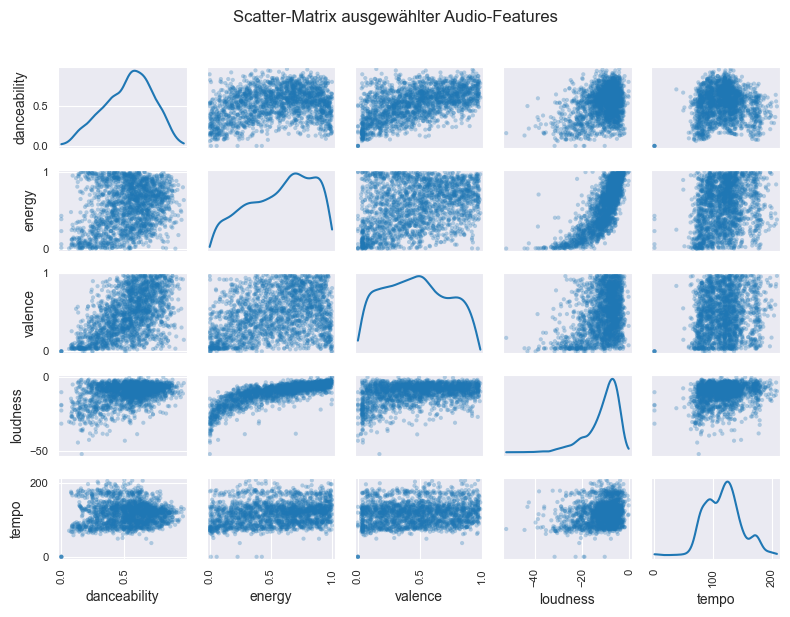

In [37]:
from pandas.plotting import scatter_matrix

SCATTER_DIR = Path(SCHEMA_REPORTS_DIR) / "scatter"
SCATTER_DIR.mkdir(parents=True, exist_ok=True)

selected_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in audio.columns]

if len(selected_cols) >= 3:
    fig = plt.figure(figsize=(8, 6))

    scatter_matrix(
        audio[selected_cols].sample(2000, random_state=42),
        figsize=(8, 6),
        alpha=0.3,
        diagonal="kde"
    )

    plt.suptitle("Scatter-Matrix ausgewählter Audio-Features", y=1.02, fontsize=12)
    plt.tight_layout()

    out_path = SCATTER_DIR / "audio_features_scatter_matrix.png"
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)

    print("saved:", out_path)


### 1.6 Missing Values & Data Completeness

**Ziel**
Ich ermittle die Datenvollständigkeit je Tabelle:
- Anteil fehlender Werte (`NaN`) pro Spalte
- Heatmap der Missing-Pattern
- Export als CSV je Tabelle

**Ergebnis**
- `missing_<table>.csv` pro Tabelle
- `missing_heatmap_<table>.png` (optional)
- Interpretation: Wo fehlen Daten signifikant?


In [38]:
from pathlib import Path
from datetime import datetime

tables = {}
for name, fname in [
    ("tracks", "tracks.csv"),
    ("audio_features", "audio_features.csv"),
    ("artists", "artists.csv"),
    ("albums", "albums.csv"),
]:
    p = DATA_DIR / fname
    if p.exists():
        tables[name] = pd.read_csv(p)


def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    ms = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
    return ms.to_frame("missing_pct")


outMissing = Path(SCHEMA_REPORTS_DIR) / "missing"
outMissing.mkdir(parents=True, exist_ok=True)

for name, df in tables.items():
    print(f"\n=== {name.upper()} ===")
    ms = missing_summary(df)
    display(ms.head(20))
    ms.to_csv(SCHEMA_REPORTS_DIR / "missing"  / f"missing_{name}.csv", encoding="utf-8")
    # Heatmap (nur bei breiten Tabellen sinnvoll)
    plt.figure(figsize=(8, 4))
    sns.heatmap(df.sample(min(len(df), 1000), random_state=42).isna(), cbar=False)
    plt.title(f"Missing-Heatmap (Sample) – {name}")
    plt.tight_layout()
    plt.savefig(SCHEMA_REPORTS_DIR / "missing" / f"missing_heatmap_{name}.png", dpi=150)
    plt.close()




=== TRACKS ===


,missing_pct
is_playable,95.33
preview_url,26.31
name,0.04
audio_feature_id,0.01
disc_number,0.00
track_id,0.00
duration,0.00
explicit,0.00
track_number,0.00
popularity,0.00



=== AUDIO_FEATURES ===


,missing_pct
id,0.0
acousticness,0.0
analysis_url,0.0
danceability,0.0
duration,0.0
energy,0.0
instrumentalness,0.0
key,0.0
liveness,0.0
loudness,0.0



=== ARTISTS ===


,missing_pct
name,0.0
id,0.0
popularity,0.0
followers,0.0



=== ALBUMS ===


,missing_pct
album_group,100.00
name,0.04
id,0.00
album_type,0.00
release_date,0.00
popularity,0.00


### 1.7 Eindeutigkeit, Duplikate & Fremdschlüssel-Integrität

**Ziel**
Ich prüfe die Datenintegrität:
- Eindeutigkeit der Primärschlüssel (z. B. `id`)
- Duplikate pro Tabelle
- Fremdschlüssel-Konsistenz (z. B. `r_track_artist.track_id` existiert in `tracks.id`)

**Ergebnis**
- `integrity_report.csv` mit Kennzahlen
- ggf. Listen der verletzten Referenzen


In [39]:
import pandas as pd
from pathlib import Path

INTEG_DIR = Path(SCHEMA_REPORTS_DIR) / "integrity"
INTEG_DIR.mkdir(parents=True, exist_ok=True)

def load(name):
    p = DATA_DIR / f"{name}.csv"
    return pd.read_csv(p) if p.exists() else None

# 2) Laden
tracks = load("tracks")
audio   = load("audio_features")
artists = load("artists")
albums  = load("albums")
rta     = load("r_track_artist")
rat     = load("r_albums_tracks")
rag     = load("r_artist_genre")
genres  = load("genres")

# 3) Utils
def key_col_for(table_name: str) -> str:
    # in deinem Export hat nur tracks die Spalte "track_id", alle anderen "id"
    return "track_id" if table_name == "tracks" else "id"

def pct(part, whole):
    return 0.0 if whole == 0 else round(100.0 * part / whole, 3)

rows = []

def report_row(table, check, status, n_bad, n_total):
    rows.append({
        "table": table,
        "check": check,
        "status": status,
        "n_bad": int(n_bad) if n_bad is not None else None,
        "n_total": int(n_total) if n_total is not None else None,
        "pct_bad": pct(n_bad, n_total) if (n_bad is not None and n_total) else None
    })

# 4) Duplikate + (optional) ID-Eindeutigkeit pro Tabelle
def check_table(table_name: str, df: pd.DataFrame):
    if df is None:
        report_row(table_name, "duplicates_all_cols", "skip", None, None)
        report_row(table_name, f"unique({key_col_for(table_name)})", "skip", None, None)
        return
    # Duplikate über alle Spalten
    dups = df.duplicated().sum()
    report_row(table_name, "duplicates_all_cols", "ok" if dups == 0 else "warn", dups, len(df))

    # ID-Eindeutigkeit wenn Key existiert
    key = key_col_for(table_name)
    if key in df.columns:
        dup_ids = df[key].duplicated().sum()
        report_row(table_name, f"unique({key})", "ok" if dup_ids == 0 else "warn", dup_ids, len(df))
    else:
        report_row(table_name, f"unique({key})", "skip", None, None)

for name, df in [("tracks", tracks), ("audio_features", audio), ("artists", artists), ("albums", albums),("genres", genres),]:
    check_table(name, df)

# 5) Fremdschlüssel-Checks (Schema-bewusst)
def fk_check(child_df, child_key, parent_df, parent_key, table_label):
    if child_df is None or parent_df is None or child_key not in child_df.columns or parent_key not in parent_df.columns:
        report_row(table_label, f"fk({child_key}->{table_label.split(':')[-1]})", "skip", None, None)
        return
    total = len(child_df)
    missing = (~child_df[child_key].isin(parent_df[parent_key])).sum()
    report_row(table_label, f"fk({child_key}->{parent_key})", "ok" if missing == 0 else "warn", missing, total)

# r_track_artist: track_id -> tracks.track_id ; artist_id -> artists.id
if rta is not None:
    fk_check(rta, "track_id", tracks, key_col_for("tracks"), "r_track_artist:tracks")
    fk_check(rta, "artist_id", artists, key_col_for("artists"), "r_track_artist:artists")

# r_albums_tracks: track_id -> tracks.track_id ; album_id -> albums.id
if rat is not None:
    fk_check(rat, "track_id", tracks, key_col_for("tracks"), "r_albums_tracks:tracks")
    fk_check(rat, "album_id", albums, key_col_for("albums"), "r_albums_tracks:albums")

# tracks.audio_feature_id -> audio_features.id
if tracks is not None and audio is not None and "audio_feature_id" in tracks.columns and "id" in audio.columns:
    total = tracks["audio_feature_id"].notna().sum()
    missing = (~tracks.loc[tracks["audio_feature_id"].notna(), "audio_feature_id"].isin(audio["id"])).sum()
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "ok" if missing == 0 else "warn", missing, total)
else:
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "skip", None, None)


fk_check(rag, "artist_id", artists, key_col_for("artists"), "r_artist_genre:artists")

fk_check(rag, "genre_id", genres, key_col_for("genres"), "r_artist_genre:genres")


# 6) Ausgabe
integ = pd.DataFrame(rows).sort_values(["table","check"]).reset_index(drop=True)
display(integ)

# Save
out_csv = INTEG_DIR / "integrity_report.csv"
integ.to_csv(out_csv, index=False, encoding="utf-8")
print(" Integrity-Report gespeichert unter:", out_csv.resolve())


,table,check,status,n_bad,n_total,pct_bad
0,albums,duplicates_all_cols,ok,0,195938,0.0
1,albums,unique(id),ok,0,195938,0.0
2,artists,duplicates_all_cols,ok,0,187440,0.0
3,artists,unique(id),ok,0,187440,0.0
4,audio_features,duplicates_all_cols,ok,0,299954,0.0
5,audio_features,unique(id),ok,0,299954,0.0
6,genres,duplicates_all_cols,ok,0,5455,0.0
7,genres,unique(id),ok,0,5455,0.0
8,r_albums_tracks:albums,fk(album_id->id),ok,0,340898,0.0
9,r_albums_tracks:tracks,fk(track_id->track_id),ok,0,340898,0.0


 Integrity-Report gespeichert unter: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\integrity\integrity_report.csv


### 1.8 Feature-Verteilungen nach Kategorien (Genre/Albumtyp)

**Ziel**
Ich vergleiche Audio-Merkmale (z. B. `energy`, `valence`, `tempo`) über **Kategorien** hinweg:
- Standard: `album_type` (z. B. album/single/compilation)
- Optional: `genre` (falls `genres` + `r_artist_genre` vorliegen)


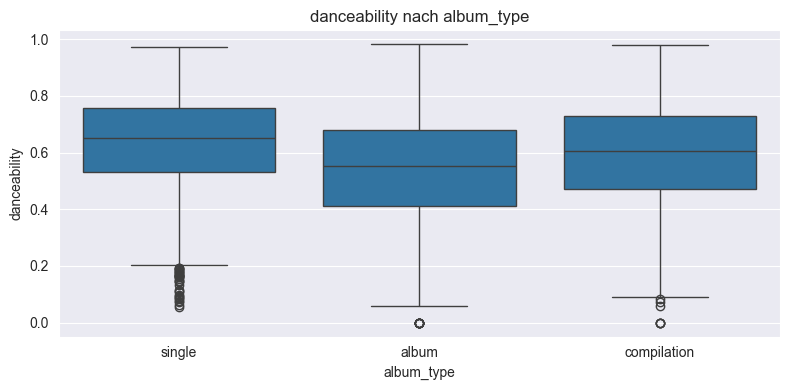

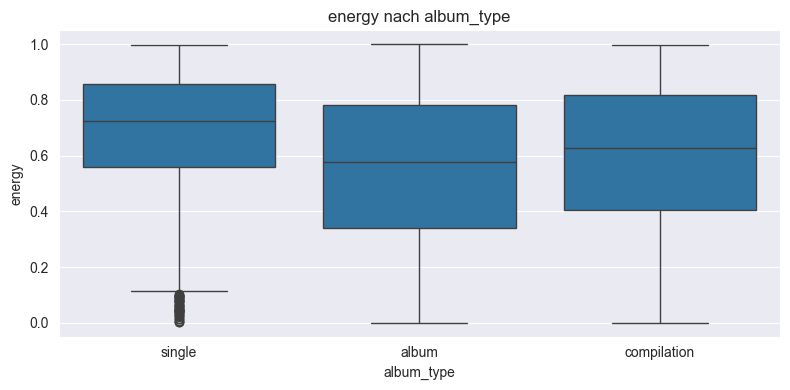

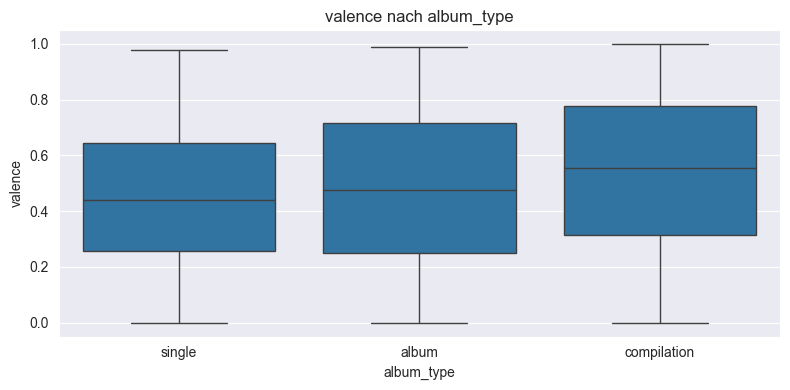

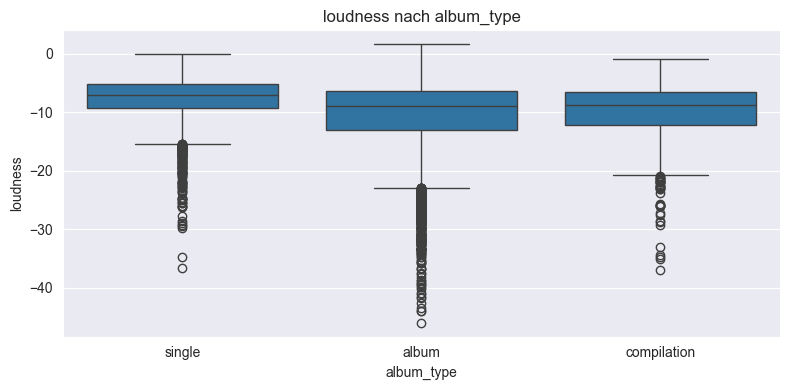

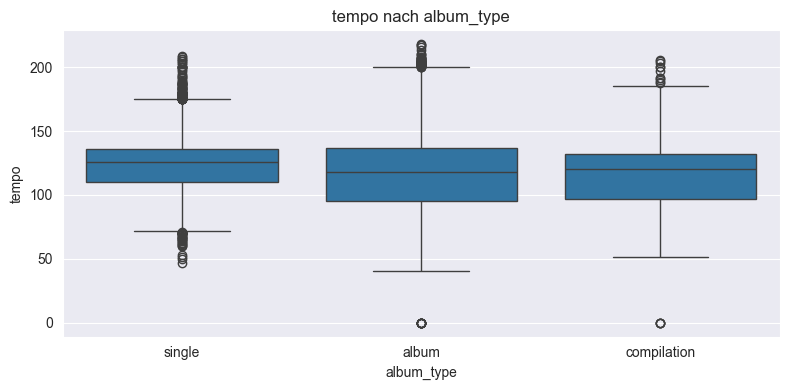

danceability                    energy                    valence  \
                    mean   std median count   mean   std median count    mean   
album_type                                                                      
album               0.54  0.19   0.55  7716   0.55  0.27   0.58  7716    0.48   
compilation         0.59  0.18   0.61  1107   0.59  0.26   0.63  1107    0.54   
single              0.63  0.16   0.65  3056   0.69  0.21   0.73  3056    0.46   

                               loudness                      tempo         \
              std median count     mean   std median count    mean    std   
album_type                                                                  
album        0.28   0.47  7716   -10.42  5.99  -8.82  7716  118.95  30.69   
compilation  0.27   0.56  1107    -9.77  4.86  -8.72  1107  118.63  28.75   
single       0.25   0.44  3056    -7.72  3.84  -7.08  3056  124.53  24.67   

                           
             median count  
album_type                 
album        118.23  7716  
compilation  120.02  1107  
single       126.00  3056

Kategorien-Auswertung gespeichert unter: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\categories


In [40]:
CAT_DIR = Path(SCHEMA_REPORTS_DIR) / "categories"
CAT_DIR.mkdir(parents=True, exist_ok=True)

# Basisdaten
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# Merge: tracks + audio + albums (für album_type + release_date)
tracks = tracks.rename(columns={"id": "track_id"})
audio = audio.rename(columns={"id": "audio_feature_id"})
df = tracks.merge(audio, left_on="audio_feature_id", right_on="audio_feature_id", how="left")
df = df.merge(albums[["id", "album_type", "release_date"]].rename(columns={"id": "album_id"}), how="left",
              left_on="track_id", right_on="album_id")

# Saubere Kategorien
cat_col = "album_type"
num_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in df.columns]

for y in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=cat_col, y=y)
    plt.title(f"{y} nach {cat_col}")
    plt.tight_layout()
    plt.savefig(CAT_DIR / f"box_{y}_by_{cat_col}.png", dpi=150)
    plt.show()

# Gruppierte Statistiken
group_stats = (
    df.groupby(cat_col)[num_cols]
    .agg(["mean", "std", "median", "count"])
    .round(2)
)
display(group_stats.head(10))
group_stats.to_csv(CAT_DIR / f"stats_{cat_col}.csv", encoding="utf-8")
print(f"Kategorien-Auswertung gespeichert unter: {CAT_DIR.resolve()}")

# Optional: nach Genre (nur wenn verfügbar)
genres_path = DATA_DIR / "genres.csv"
rag_path = DATA_DIR / "r_artist_genre.csv"
rta_path = DATA_DIR / "r_track_artist.csv"
artists_path = DATA_DIR / "artists.csv"

if genres_path.exists() and rag_path.exists() and rta_path.exists() and artists_path.exists():
    genres = pd.read_csv(genres_path)
    rag = pd.read_csv(rag_path)
    rta = pd.read_csv(rta_path)
    artists = pd.read_csv(artists_path)
    # Map track -> artist -> genre (First genre per artist)
    first_genre = rag.merge(genres, left_on="genre_id", right_on="id", how="left").dropna(subset=["id"])
    first_genre = first_genre.drop_duplicates(subset=["artist_id"]).rename(columns={"id": "genre_name"})
    track_genre = rta.merge(first_genre[["artist_id", "genre_name"]], on="artist_id", how="left")
    df_g = tracks.merge(track_genre[["track_id", "genre_name"]], on="track_id", how="left").merge(audio,
                                                                                                  on="audio_feature_id",
                                                                                                  how="left")
    # Top 15 Genres
    top_genres = df_g["genre_name"].value_counts().head(15).index
    df_g = df_g[df_g["genre_name"].isin(top_genres)]
    for y in num_cols:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_g, x="genre_name", y=y)
        plt.title(f"{y} nach Genre (Top 15)")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.savefig(CAT_DIR / f"box_{y}_by_genre_top15.png", dpi=150)
        plt.close()



### 1.9 Zeitliche Trends (Release-Jahre)

**Ziel**
Ich analysiere die Entwicklung musikalischer Merkmale über die Zeit (pro Jahr):
- Jahresdurchschnitt von `tempo`, `energy`, `valence`, `loudness`
- Gleitender Durchschnitt (k=3) zur Glättung

**Ergebnis**
- `yearly_trends.csv`
- Trendplots als PNG


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

TREND_DIR = Path(SCHEMA_REPORTS_DIR) / "trends"
TREND_DIR.mkdir(parents=True, exist_ok=True)

# Load
tracks = pd.read_csv(DATA_DIR / "tracks.csv").rename(columns={"id": "track_id"})
audio  = pd.read_csv(DATA_DIR / "audio_features.csv").rename(columns={"id": "audio_feature_id"})
albums = pd.read_csv(DATA_DIR / "albums.csv")[["id", "release_date"]].rename(columns={"id": "album_id"})

# Optional relation (best way to map tracks -> albums)
rat_path = DATA_DIR / "r_albums_tracks.csv"
r_at = pd.read_csv(rat_path) if rat_path.exists() else None

# Base merge (tracks + audio)
df = tracks.merge(audio, on="audio_feature_id", how="left")

# Attach album_id properly
if r_at is not None:
    df = df.merge(r_at[["track_id", "album_id"]], on="track_id", how="left")
elif "album_id" in tracks.columns:
    df = df.merge(tracks[["track_id", "album_id"]], on="track_id", how="left")
else:
    df["album_id"] = pd.NA

# Join albums to get release_date
df = df.merge(albums, on="album_id", how="left")

# Parse release_date: it's ms timestamps (per your sample)
# (works whether dtype is str, int, or float)
s = pd.to_numeric(df["release_date"], errors="coerce")
df["release_dt"] = pd.to_datetime(s, unit="ms", errors="coerce")
df["year"] = df["release_dt"].dt.year

# Features & yearly aggregation
feat_cols = [c for c in ["tempo", "energy", "valence", "loudness", "danceability"] if c in df.columns]
yearly = (
    df.dropna(subset=["year"])
      .groupby("year")[feat_cols]
      .mean()
      .round(3)
)

# Add counts to judge stability; optionally filter sparse years
yearly["count"] = df.groupby("year")["track_id"].count()
MIN_YEAR_COUNT = 50
yearly_filtered = yearly[yearly["count"] >= MIN_YEAR_COUNT]

# Save table
yearly_filtered.to_csv(TREND_DIR / "yearly_trends.csv", encoding="utf-8", index=True)

# Plots: per-feature trend + 3Y rolling mean (dashed)
for c in feat_cols:
    s = yearly_filtered[c].dropna()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=s.index, y=s.values, marker="o")
    if len(s) >= 3:
        s_roll = s.rolling(3, min_periods=1).mean()
        sns.lineplot(x=s_roll.index, y=s_roll.values, linestyle="--")
    plt.title(f"Trend über Jahre: {c} (Ø, 3Y-Rolling gestrichelt)")
    plt.xlabel("Jahr"); plt.ylabel(c)
    plt.tight_layout()
    plt.savefig(TREND_DIR / f"trend_{c}.png", dpi=150)
    plt.close()

print(f" Trend-Reports gespeichert unter: {TREND_DIR.resolve()}")



 Trend-Reports gespeichert unter: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\trends


## 1.10 Cross-Table Relationship: Artist Influence

**Ziel**
Ich untersuche, ob **Künstler-Reichweite** (Followers) mit **Erfolg ihrer Songs** (Ø-Track-Popularität) zusammenhängt.

**Ergebnis**
- Scatter + Regressionslinie (log-Followers)
- `artist_influence.csv`


In [42]:
INF_DIR = Path(SCHEMA_REPORTS_DIR) / "influence"
INF_DIR.mkdir(parents=True, exist_ok=True)

# --- Helpers to resolve column names across schema variants
def pick(dframe, candidates, required=True):
    for c in candidates:
        if c in dframe.columns:
            return c
    if required:
        raise KeyError(f"None of {candidates} found in columns: {list(dframe.columns)}")
    return None

# --- Load CSVs
tracks = pd.read_csv(DATA_DIR / "tracks.csv", encoding="utf-8")  # ensure headers load
artists = pd.read_csv(DATA_DIR / "artists.csv", encoding="utf-8")
rta = pd.read_csv(DATA_DIR / "r_track_artist.csv", encoding="utf-8")

# --- Resolve column names
track_id_col = pick(tracks, ["track_id", "id"])
track_pop_col = pick(tracks, ["popularity"])

artist_id_col = pick(artists, ["artist_id", "id"])
followers_col  = pick(artists, ["followers", "followers_count"])
artist_pop_col = pick(artists, ["artist_popularity", "popularity"], required=False)  # optional

rta_track_col  = pick(rta, ["track_id", "trackId", "trackID"])
rta_artist_col = pick(rta, ["artist_id", "artistId", "artistID"])

# --- Minimal frames with normalized names
tracks_min = tracks[[track_id_col, track_pop_col]].rename(
    columns={track_id_col: "track_id", track_pop_col: "track_popularity"}
)

artists_min_cols = [artist_id_col, followers_col]
rename_map = {artist_id_col: "artist_id", followers_col: "followers"}
if artist_pop_col:
    artists_min_cols.append(artist_pop_col)
    rename_map[artist_pop_col] = "artist_popularity"

artists_min = artists[artists_min_cols].rename(columns=rename_map)

rta_min = rta[[rta_track_col, rta_artist_col]].rename(
    columns={rta_track_col: "track_id", rta_artist_col: "artist_id"}
)

# --- Avg track popularity per artist
track_pop_by_artist = (
    rta_min.merge(tracks_min, on="track_id", how="left")
           .groupby("artist_id", as_index=False)["track_popularity"]
           .mean()
           .rename(columns={"track_popularity": "avg_track_popularity"})
)

# --- Combine with artist followers (and optional artist_popularity)
df = artists_min.merge(track_pop_by_artist, on="artist_id", how="left")
df = df.dropna(subset=["avg_track_popularity"])

# Followers cleaning: ensure non-negative numbers
df["followers"] = pd.to_numeric(df["followers"], errors="coerce").fillna(0).clip(lower=0)

# Log-transform followers (log1p handles zeros)
df["followers_log1p"] = np.log1p(df["followers"])

# --- Plot: Scatter + regression line
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df,
    x="followers_log1p",
    y="avg_track_popularity",
    scatter_kws={"alpha": 0.4, "s": 18},
    line_kws={"linewidth": 2}
)
plt.title("Artist-Followers (log) vs. Ø Track-Popularität")
plt.xlabel("Followers (log1p)")
plt.ylabel("Ø Track-Popularität")
plt.tight_layout()
plt.savefig(INF_DIR / "artist_followers_vs_avg_track_popularity.png", dpi=150)
plt.close()

# --- Save CSV
cols_out = ["artist_id", "followers", "avg_track_popularity", "followers_log1p"]
if "artist_popularity" in df.columns:
    cols_out.insert(2, "artist_popularity")

df[cols_out].to_csv(INF_DIR / "artist_influence.csv", index=False, encoding="utf-8-sig")

print(f" Artist-Influence gespeichert unter: {INF_DIR.resolve()}")
print("Columns used:",
      {"tracks": list(tracks_min.columns),
       "artists": list(artists_min.columns),
       "r_track_artist": list(rta_min.columns)})



 Artist-Influence gespeichert unter: C:\GitHub\uni-project-metrics-and-data\data\reports\schema_overview\slice_001\influence
Columns used: {'tracks': ['track_id', 'track_popularity'], 'artists': ['artist_id', 'followers', 'artist_popularity'], 'r_track_artist': ['track_id', 'artist_id']}
